# <font color='darkred'>Home Credit Default Risk Competition</font>

### Overview:
- Home Credit makes use of a variety of alternative data including telco and transactional information to predict their clients' repayment abilities. This competition is currently hosted on Kaggle

### Problem statement:
- The objective of this competition is to use historical loan application data to predict to predict their clients' repayment abilities (whether an applicant will be able to repay a loan). This is a standard supervised classification task

### Scope:
- Due to the computational and time constraint as well as the unavailability of a spark cluster to work on only the main dataset (application_train.csv) will be used.

In [ ]:
# install libraries required for this notebook
!sudo pip install pandas_profiling
!sudo pip install imbalanced-learn
!sudo pip install lightgbm
!sudo pip install bayesian-optimization

### <font color='darkred'>Import Needed libraries and read the data</font>

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
# import pandas profiling for basic EDA
import pandas_profiling as pp
# File system manangement
import os
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('application_train.csv').drop(['SK_ID_CURR'],axis=1)
df.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 121 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 283.9+ MB


In [5]:
print('The taining data shape is:', df.shape)
df.columns

The taining data shape is: (307511, 121)


Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

### <font color='darkred'> Automated Exploratory Data Analysis </font>

In [6]:
pp_report = pp.ProfileReport(df, minimal=True)
pp_report.to_file("EDA.html")

Summarize dataset:   0%|          | 0/129 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
pp_report.to_notebook_iframe()

### <font color='darkred'> Handle missing data</font>

AMT_ANNUITY                   , Rows: 307511, NAs: 12                  , precentage: 0.0%
AMT_GOODS_PRICE               , Rows: 307511, NAs: 278                 , precentage: 0.09%
NAME_TYPE_SUITE               , Rows: 307511, NAs: 1292                , precentage: 0.42%
OWN_CAR_AGE                   , Rows: 307511, NAs: 202929              , precentage: 65.99%
OCCUPATION_TYPE               , Rows: 307511, NAs: 96391               , precentage: 31.35%
CNT_FAM_MEMBERS               , Rows: 307511, NAs: 2                   , precentage: 0.0%
EXT_SOURCE_1                  , Rows: 307511, NAs: 173378              , precentage: 56.38%
EXT_SOURCE_2                  , Rows: 307511, NAs: 660                 , precentage: 0.21%
EXT_SOURCE_3                  , Rows: 307511, NAs: 60965               , precentage: 19.83%
APARTMENTS_AVG                , Rows: 307511, NAs: 156061              , precentage: 50.75%
BASEMENTAREA_AVG              , Rows: 307511, NAs: 179943              , precentage: 58

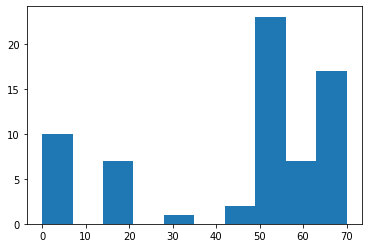

In [8]:
def count_NAs(dfna, perc):
    '''
    A function made to measure the percentage of nulls in each column
    and return a list of the columns to be dropped based on the cutoff percentage number
    parameters: 
        dfna Dataframe: a df to be analyzed
        perc float: the cutoff for a column to be included in the NAs list
    '''
    NaList = []
    perc_list = []
    numOfRows = len(dfna)
    for i in dfna.columns:
        numOfNAs = dfna[i].isna().sum()
        if numOfNAs == 0:
            continue
        print(f'{i:<30}, Rows: {numOfRows:>5}, NAs: {numOfNAs:<20}, precentage: {round(numOfNAs/numOfRows * 100.000,2)}%')
        perc_list.append(round(numOfNAs/numOfRows * 100.000,0))
        if ((numOfNAs/numOfRows) * 100.000) >= perc:
           NaList.append(i)
    print(f'columns with NAs over {perc}%: {NaList}')
    plt.hist(np.array(perc_list))
    return NaList
# Display NAs
cutoff_perc = 50
NAs = count_NAs(df, cutoff_perc)
print(f"Total with NAs over {cutoff_perc}% column number :",len(NAs))

AMT_ANNUITY                   , Rows: 307511, NAs: 12                  , precentage: 0.0%
AMT_GOODS_PRICE               , Rows: 307511, NAs: 278                 , precentage: 0.09%
NAME_TYPE_SUITE               , Rows: 307511, NAs: 1292                , precentage: 0.42%
OCCUPATION_TYPE               , Rows: 307511, NAs: 96391               , precentage: 31.35%
CNT_FAM_MEMBERS               , Rows: 307511, NAs: 2                   , precentage: 0.0%
EXT_SOURCE_2                  , Rows: 307511, NAs: 660                 , precentage: 0.21%
EXT_SOURCE_3                  , Rows: 307511, NAs: 60965               , precentage: 19.83%
YEARS_BEGINEXPLUATATION_AVG   , Rows: 307511, NAs: 150007              , precentage: 48.78%
FLOORSMAX_AVG                 , Rows: 307511, NAs: 153020              , precentage: 49.76%
YEARS_BEGINEXPLUATATION_MODE  , Rows: 307511, NAs: 150007              , precentage: 48.78%
FLOORSMAX_MODE                , Rows: 307511, NAs: 153020              , precentage: 49

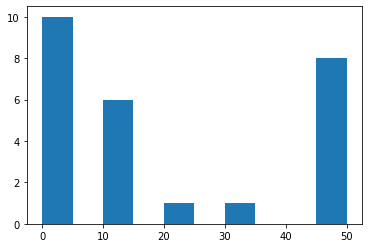

In [9]:
df.drop(NAs, axis = 1, inplace = True)
# Display NAs
cutoff_perc = 50
NAs = count_NAs(df, cutoff_perc)
print(f"Total with NAs over {cutoff_perc}% column number :",len(NAs))

In [10]:
# create flag for missing values 
df['is_missing'] = np.where(df.notna().all(axis=1), True, False)
df.groupby(['TARGET','is_missing'])['NAME_CONTRACT_TYPE'].count()

TARGET  is_missing
0       False         204387
        True           78299
1       False          18549
        True            6276
Name: NAME_CONTRACT_TYPE, dtype: int64

### <font color='darkred'> Handle Outliers</font>
- A lot of outliers was observed across the dataset (please check the interactive EDA) 
- Days_employed appear to be a prime example of such a case
- There are strange values in the days_employed that needs to be trimed and there may exist outloers in the whole data that needs to be addresses

<AxesSubplot:xlabel='DAYS_EMPLOYED'>

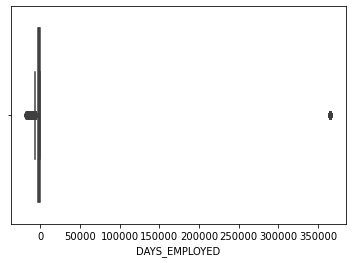

In [11]:
# Visualize the outliers within this column
sns.boxplot(x=df['DAYS_EMPLOYED'])

In [12]:
# Detect outliers from the entire datset
numer_col = df.select_dtypes(include=[np.number]).columns.to_list()
numer_col.remove('TARGET')
Q1 = df[numer_col].quantile(0.25)
Q3 = df[numer_col].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
outliers = ~((df[numer_col] < (Q1 - 1.5 * IQR)) |(df[numer_col] > (Q3 + 1.5 * IQR))).any(axis=1)
# Create a flag for the outliers in this column
df['DAYS_EMPLOYED_ANOM'] = outliers
# To do!! consider creating a flag for each column then reducing the data via feature importance and PCA

CNT_CHILDREN                       1.0
AMT_INCOME_TOTAL               90000.0
AMT_CREDIT                    538650.0
AMT_ANNUITY                    18072.0
AMT_GOODS_PRICE               441000.0
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY          0.0
AMT_REQ_CREDIT_BUREAU_WEEK         0.0
AMT_REQ_CREDIT_BUREAU_MON          0.0
AMT_REQ_CREDIT_BUREAU_QRT          0.0
AMT_REQ_CREDIT_BUREAU_YEAR         3.0
Length: 66, dtype: float64


<AxesSubplot:xlabel='DAYS_EMPLOYED'>

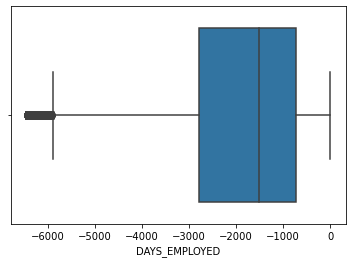

In [13]:
# Replace all outliers with NANs for later corrections
IQR_condition = (df[numer_col]< (Q1 - 1.5 * IQR)) |(df[numer_col] > (Q3 + 1.5 * IQR))
df_anom = pd.DataFrame(np.where(IQR_condition, np.nan, df[numer_col]), columns = numer_col)
df[numer_col] = df_anom[numer_col]
# Visualize the column after the outliers were handled
sns.boxplot(x=df['DAYS_EMPLOYED'])

In [20]:
df.groupby(['TARGET','DAYS_EMPLOYED_ANOM'])['DAYS_EMPLOYED'].count()

TARGET  DAYS_EMPLOYED_ANOM
0       False                 182655
        True                   31540
1       False                  18333
        True                    2766
Name: DAYS_EMPLOYED, dtype: int64

### <font color='darkred'> Cluster missing data for later profiling</font>

In [21]:
# create a df carrying only the records with missing values
missing_df = df[(df.is_missing == True)|(df.DAYS_EMPLOYED_ANOM == True)].copy()

In [22]:
from sklearn.preprocessing import LabelEncoder

# Label Encode cols with only 2 unique values or less
lEncoder = LabelEncoder()
# Iterate through the columns
for col in df.columns:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # Train on the training data
            lEncoder.fit(df[col])
            df[col] = lEncoder.transform(df[col])
            
            
# one-hot encoding of categorical variables
df = pd.get_dummies(df)

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_kmeans(num_components, rtype: str):

    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=num_components, random_state=10)
    clusterer.fit(scaled_features)

    # Predict the cluster for each data point
    preds = clusterer.predict(scaled_features)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Predict the cluster for each transformed sample data point
    # sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(scaled_features, preds)
    
    if rtype == 'score':
        return score
    if  rtype == 'centers':
        return centers
    if rtype == 'pred':
        print(pd.Series(preds).value_counts())
        return preds

In [24]:
 # Min Max Scaler
from sklearn.preprocessing import MinMaxScaler
missing_df_filled = missing_df.fillna(-100000)
scaler = MinMaxScaler().fit(missing_df_filled)
scaled_features = scaler.transform(missing_df_filled)
scaled_df = pd.DataFrame(scaled_features, columns= missing_df_filled.columns)
scaled_df.shape

(106763, 192)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

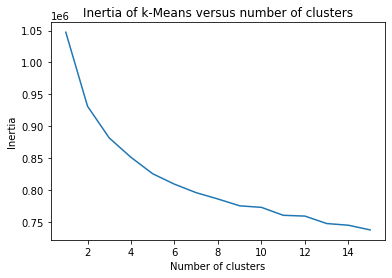

In [25]:
import matplotlib.pyplot as plt
scores = [KMeans(n_clusters=i+1).fit(scaled_features).inertia_ 
          for i in range(15)]
sns.lineplot(np.arange(1, 16), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [27]:
k_centers_6 = cluster_kmeans(6,'centers')
K_cents_6 = pd.DataFrame(scaler.inverse_transform(k_centers_6), columns= missing_df_filled.columns)
K_cents_6.head()

TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0  0.098708            0.098416      0.569319         0.664966  -1209.094967   
1  0.047438            0.126924      0.332368         0.696328  -1030.561887   
2  0.093836            0.134117      0.276472         0.737412      0.395331   
3  0.070959            0.111352      0.607895         0.662364  -1157.218956   
4  0.084699            0.135414      0.355180         0.698570      0.494322   

   AMT_INCOME_TOTAL     AMT_CREDIT   AMT_ANNUITY  AMT_GOODS_PRICE  \
0     161479.762120  558904.963155  24140.947367    462674.036797   
1     152969.930637  607499.061837  22638.848215    488171.626568   
2     140904.002746  500906.766326  24496.636405    444786.295163   
3     153765.538584  609763.763180  23322.415091    489326.401432   
4     148802.456957  543630.722887  24485.993758    478625.681274   

   REGION_POPULATION_RELATIVE  ...  ORGANIZATION_TYPE_Trade: type 6  \
0                -1865.327080  ...                         0.001069   
1                -5048.485314  ...                         0.003809   
2                    0.018473  ...                         0.002746   
3                -9661.011285  ...                         0.002082   
4                    0.019753  ...                         0.002341   

   ORGANIZATION_TYPE_Trade: type 7  ORGANIZATION_TYPE_Transport: type 1  \
0                         0.018362                             0.000826   
1                         0.029001                             0.000406   
2                         0.048062                             0.000458   
3                         0.021904                             0.000916   
4                         0.034070                             0.000780   

   ORGANIZATION_TYPE_Transport: type 2  ORGANIZATION_TYPE_Transport: type 3  \
0                             0.016468                             0.011513   
1                             0.008685                             0.000914   
2                             0.003204                             0.006408   
3                             0.008828                             0.008412   
4                             0.007022                             0.004768   

   ORGANIZATION_TYPE_Transport: type 4  ORGANIZATION_TYPE_University  \
0                             0.041193                      0.003886   
1                             0.013612                      0.013662   
2                             0.017547                      0.004425   
3                             0.030899                      0.006746   
4                             0.014911                      0.003988   

   ORGANIZATION_TYPE_XNA  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
0                    0.0                0.986544                 0.013456  
1                    0.0                0.991975                 0.008025  
2                    0.0                0.569118                 0.006561  
3                    0.0                0.992171                 0.007829  
4                    0.0                0.030603                 0.003554  

[5 rows x 192 columns]

In [28]:
cluster_ids = cluster_kmeans(6,'pred') # return array of clusters sorted by the same index as data
cluster_data_complete = missing_df_filled.copy()
cluster_data_complete['cluster_id'] = cluster_ids 
cluster_data_complete.head() # complete data

5    36394
0    20579
1    19688
3    12013
4    11535
2     6554
dtype: int64


TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0        1                   0             0                1           0.0   
3        0                   0             0                1           0.0   
9        0                   1             0                1           0.0   
12       0                   0             0                1           0.0   
13       0                   0             1                0           1.0   

    AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           202500.0    406597.5      24700.5         351000.0   
3           135000.0    312682.5      29686.5         297000.0   
9           135000.0    405000.0      20250.0         405000.0   
12           67500.0     80865.0       5881.5          67500.0   
13          225000.0    918468.0      28966.5         697500.0   

    REGION_POPULATION_RELATIVE  ...  ORGANIZATION_TYPE_Trade: type 7  \
0                     0.018801  ...                                0   
3                     0.008019  ...                                0   
9                     0.019689  ...                                0   
12                    0.031329  ...                                0   
13                    0.016612  ...                                0   

    ORGANIZATION_TYPE_Transport: type 1  ORGANIZATION_TYPE_Transport: type 2  \
0                                     0                                    0   
3                                     0                                    0   
9                                     0                                    0   
12                                    0                                    0   
13                                    0                                    0   

    ORGANIZATION_TYPE_Transport: type 3  ORGANIZATION_TYPE_Transport: type 4  \
0                                     0                                    0   
3                                     0                                    0   
9                                     0                                    0   
12                                    0                                    0   
13                                    0                                    0   

    ORGANIZATION_TYPE_University  ORGANIZATION_TYPE_XNA  \
0                              0                      0   
3                              0                      0   
9                              0                      0   
12                             0                      0   
13                             0                      0   

    EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  cluster_id  
0                        1                        0           0  
3                        0                        0           2  
9                        0                        0           2  
12                       1                        0           5  
13                       1                        0           0  

[5 rows x 193 columns]

In [29]:
# remove the missing records data from the majority class only
df = df[~((df.TARGET == 0) & (df.is_missing == True))]
df = df[~((df.TARGET == 0) & (df.DAYS_EMPLOYED_ANOM == True))]

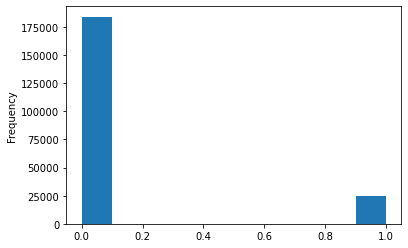

In [30]:
# visualize the unbalanced classes
df['TARGET'].plot.hist();

### <font color='darkred'> Data imputation & prep</font>

In [32]:
# split the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     df.drop(['TARGET'], axis=1), df['TARGET'], test_size=0.2, random_state=42)


In [33]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

### Data Imputation

In [37]:
# method for data imputation using kmeans
from sklearn.cluster import KMeans

def kmeans_missing(X, X_test, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)
    
    # Initialize missing values to their column means
    missing_test = ~np.isfinite(X_test)
    mu_test = np.nanmean(X_test, 0, keepdims=1)
    X_test_hat = np.where(missing_test, mu_test, X_test)
    
    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        cc = cls.fit(X_hat) # fit using the train data only to avoid data leakage
        labels = cc.predict(X_hat)
        centroids = cls.cluster_centers_
        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]
        
        # perform clustering on the filled-in test data
        test_labels = cc.predict(X_test_hat)
        centroids_test = cls.cluster_centers_
        # fill in the missing values based on their cluster centroids
        X_test_hat[missing_test] = centroids[test_labels][missing_test]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return X_hat, X_test_hat

In [38]:
print('X_train_norm shape is', X_train_norm.shape)
print('X_test_norm shape is', X_test_norm.shape)

X_train_norm shape is (175507, 191)
X_test_norm shape is (43877, 191)


In [39]:
X_train_filled, X_test_filled = kmeans_missing(X_train_norm, X_test_norm, n_clusters=50, max_iter=2)
X_train_filled = pd.DataFrame(X_train_filled, columns= X_train_norm.columns)
X_test_filled = pd.DataFrame(X_test_filled, columns= X_test_norm.columns)
print('X_train_filled shape is', X_train_filled.shape)
print('X_test_filled shape is', X_test_filled.shape)

X_train_filled shape is (175507, 191)
X_test_filled shape is (43877, 191)


#### Data upsampling

In [40]:
from imblearn.over_sampling import SMOTE

def resamplingDataPrep(X_train, y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class

In [41]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [42]:
X_train_sm, y_train_sm = upsample_SMOTE(X_train_filled, y_train, 0.85)

288165 288165


In [49]:
np.unique(y_train_sm, return_counts=True)

(array([0, 1]), array([155765, 132400]))

#### Feature importance

In [205]:
from sklearn.ensemble import RandomForestClassifier

# Creating a decision tree regressor and fit it to the training set
cls_imp = RandomForestClassifier(n_jobs=-1,random_state = 40)
cls_imp.fit(X_train_sm, y_train_sm)
feat_importances = pd.Series(cls_imp.feature_importances_, index=X_train_sm.columns)

<AxesSubplot:>

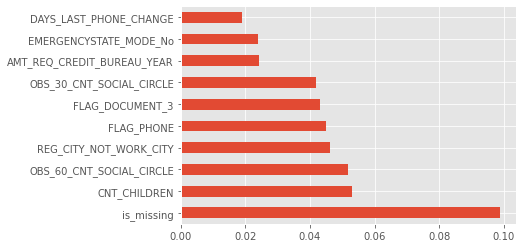

In [214]:
#plot graph of feature importances for better visualization
plt.style.use('ggplot')
feat_importances.sort_values(ascending=False).nlargest(10).plot(kind='barh')

#### Correlation

In [216]:
X_corr = X_train_filled.copy()
X_corr['TARGET'] = y_train
X_corr.head()

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 0.0           1.0              1.0      0.000000   
1                 0.0           1.0              0.0      0.000000   
2                 0.0           1.0              1.0      0.000000   
3                 0.0           1.0              1.0      0.000000   
4                 0.0           0.0              1.0      0.167972   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.060734    0.024013     0.063810         0.010417   
1          0.555085    0.198610     0.610025         0.208333   
2          0.413842    0.176825     0.366124         0.208333   
3          0.272599    0.235767     0.532140         0.277778   
4          0.413842    0.149736     0.283312         0.156250   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
0                    0.232441    0.304991  ...   
1                    0.617744    0.804370  ...   
2                    0.409558    0.708107  ...   
3                    0.617744    0.768406  ...   
4                    0.675789    0.809621  ...   

   ORGANIZATION_TYPE_Trade: type 7  ORGANIZATION_TYPE_Transport: type 1  \
0                              0.0                                  0.0   
1                              0.0                                  0.0   
2                              0.0                                  0.0   
3                              0.0                                  0.0   
4                              0.0                                  0.0   

   ORGANIZATION_TYPE_Transport: type 2  ORGANIZATION_TYPE_Transport: type 3  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   ORGANIZATION_TYPE_Transport: type 4  ORGANIZATION_TYPE_University  \
0                                  0.0                           0.0   
1                                  0.0                           0.0   
2                                  0.0                           0.0   
3                                  0.0                           0.0   
4                                  0.0                           0.0   

   ORGANIZATION_TYPE_XNA  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                    0.0                     0.0                      0.0   
1                    1.0                     0.0                      0.0   
2                    1.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     1.0                      0.0   

   TARGET  
0     1.0  
1     0.0  
2     0.0  
3     NaN  
4     0.0  

[5 rows x 192 columns]

In [220]:
corrs = X_corr.corr()[['TARGET']]

In [226]:
corrs.columns

Index(['TARGET'], dtype='object')

<AxesSubplot:>

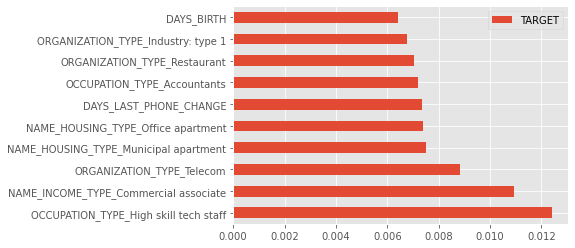

In [234]:
corrs.drop('TARGET').sort_values(by = 'TARGET',ascending=False).nlargest(10, columns= 'TARGET').plot(kind='barh')

<AxesSubplot:>

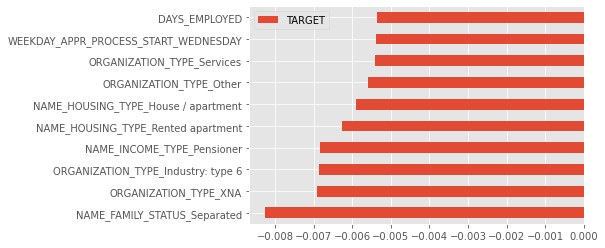

In [235]:
corrs.drop('TARGET').sort_values(by = 'TARGET',ascending=False).nsmallest(10, columns= 'TARGET').plot(kind='barh')

#### Dimensionality Reduction

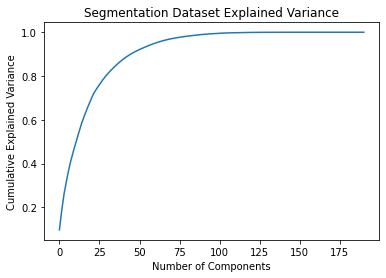

In [60]:
from sklearn.decomposition import PCA

# Fitting the PCA algorithm with our Data
pca = PCA()
pca.fit(X_train_sm)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('Segmentation Dataset Explained Variance')
plt.show(block=True)

In [62]:
pca = PCA(n_components=80)
pca.fit(X_train_sm)
trainX_pca = pca.transform(X_train_sm)
testX_pca = pca.transform(X_test_filled)

### <font color='darkred'>Data Modeling </font>

#### Base Model

In [64]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

# Train the model
logisticRegr.fit(trainX_pca, y_train_sm)

LogisticRegression()

In [78]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
pred = logisticRegr.predict(testX_pca)

print('Accuracy for base model is ', accuracy_score(y_test, pred))
print('F1 for base model is ', f1_score(y_test, pred))
print('Precision for base model is ', precision_score(y_test, pred))
print('Recall for base model is ', recall_score(y_test, pred))


Accuracy for base model is  0.8236661576680265
F1 for base model is  0.3758973945309349
Precision for base model is  0.31856713152857535
Recall for base model is  0.45839071414518984


#### Random Forest

In [132]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(trainX_pca, y_train_sm)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [133]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
rf_pred = clf.predict(testX_pca)

print('Accuracy for base model is ', accuracy_score(y_test, rf_pred))
print('F1 for base model is ', f1_score(y_test, rf_pred))
print('Precision for base model is ', precision_score(y_test, rf_pred))
print('Recall for base model is ', recall_score(y_test, rf_pred))


Accuracy for base model is  0.903525765207284
F1 for base model is  0.4152507252382926
Precision for base model is  0.6971243042671614
Recall for base model is  0.29569152075545935


#### Random Forest using random search

In [201]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [203]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_jobs = -1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, scoring='f1', param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(trainX_pca, y_train_sm.to_numpy())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 31, 52, 73, 94,
                                                         115, 136, 157, 178,
                                                         200]},
                   random_state=42, scoring='f1', verbose=10)

In [204]:
best_rf = rf_random.best_estimator_

best_rf_pred = best_rf.predict(testX_pca)

print('Accuracy for base model is ', accuracy_score(y_test, best_rf_pred))
print('F1 for base model is ', f1_score(y_test, best_rf_pred))
print('Precision for base model is ', precision_score(y_test, best_rf_pred))
print('Recall for base model is ', recall_score(y_test, best_rf_pred))

Accuracy for base model is  0.9053034619504524
F1 for base model is  0.4163506110408765
Precision for base model is  0.7278978388998035
Recall for base model is  0.2915601023017903


The observed f1 is the same as the unoptimized model so we need to find a diff way to optimize the tree or change the search space or try a different model/features

#### Random Forest using Baysien optimization

In [169]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
   X_train, y_train, X_test, y_test = dataset
   n_iterations = 10
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, **gp_params)

   return BO.max

In [181]:
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=42,   
                   class_weight="balanced"),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="f1",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
    
    return function, parameters

In [182]:
#Train model
def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 10
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model

In [ ]:
function, parameters = rfc_optimization(10)
best_rf_model = train(trainX_pca, y_train_sm.to_numpy(), testX_pca, y_test.to_numpy(), function, parameters)

### <font color = 'darkred'>Thank you</font>